## Testing individual sentences

In [1]:
from seq2seq.data.dictionary import Dictionary
import collections
import re
import torch
from seq2seq import models
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


torch.manual_seed(42)

SPACE_NORMALIZER = re.compile("\s+")

src_dict =Dictionary.load('europarl_prepared/dict.de')
tgt_dict = Dictionary.load('europarl_prepared/dict.en')


def load_model(model_path):
    state_dict = torch.load(model_path)
    source_lang, target_lang = 'de', 'en'
    # src_dict = Dictionary.load(os.path.join(data, 'dict.{:s}'.format(source_lang)))
    # print('Loaded a source dictionary ({:s}) with {:d} words'.format(source_lang, len(src_dict)))
    # tgt_dict = Dictionary.load(os.path.join(data, 'dict.{:s}'.format(target_lang)))
    # print('Loaded a target dictionary ({:s}) with {:d} words'.format(target_lang, len(tgt_dict)))
        # Build model and optimization criterion
    model = models.build_model(state_dict['args'], src_dict, tgt_dict)
    model.eval()
    model.load_state_dict(state_dict['model'])
    return model, state_dict['args']


/Users/shobhitmaheshwari/miniconda3/envs/nlu2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:



def word_tokenize(line):
    line = SPACE_NORMALIZER.sub(" ", line)
    line = line.strip()
    return line.split()

unk_counter = collections.Counter()

def unk_consumer(word, idx):
    if idx == src_dict.unk_idx and word != src_dict.unk_word:
        unk_counter.update([word])

def merge(values, move_eos_to_beginning=False):
    max_length = max(v.size(0) for v in values)
    result = values[0].new(len(values), max_length).fill_(src_dict.pad_idx)
    for i, v in enumerate(values):
        if move_eos_to_beginning:
            assert v[-1] == src_dict.eos_idx
            result[i, 0] = src_dict.eos_idx
            result[i, 1:len(v)] = v[:-1]
        else:
            result[i, :len(v)].copy_(v)
    return result


def generate_tokens(lines):  
    tokens_list, len_list = [], []
    for line in lines:

        tokens = src_dict.binarize(line.strip(), word_tokenize, append_eos=True, consumer=unk_consumer)
    
        tokens = torch.tensor([tokens.numpy()]).to(torch.int64)
        tokens = merge([s for s in tokens])
        lengths = torch.LongTensor([s.numel() for s in tokens])
        lengths, sort_order = lengths.sort(descending=True)
        tokens.index_select(0, sort_order)
        tokens_list.append(tokens)
        len_list.append(lengths)
    return tokens_list, len_list


In [3]:


def generate_output(model, tokens, lengths, arch, max_len = 25):
    all_hyps, attn_weights_all = {}, []
    for i, _ in enumerate(tokens):
        with torch.no_grad():
            encoder_out = model.encoder(tokens[i], lengths[i])
            go_slice = \
                torch.ones(tokens[i].shape[0], 1).fill_(tgt_dict.eos_idx).type_as(tokens[i])
            prev_words = go_slice
            next_words = None
        for _ in range(max_len):
            with torch.no_grad():
                # Compute the decoder output by repeatedly feeding it the decoded sentence prefix
                decoder_out, attn_weights = model.decoder(prev_words, encoder_out)
            # Suppress <UNK>s
            _, next_candidates = torch.topk(decoder_out, 2, dim=-1)
            best_candidates = next_candidates[:, :, 0]
            backoff_candidates = next_candidates[:, :, 1]
            next_words = torch.where(best_candidates == tgt_dict.unk_idx, backoff_candidates, best_candidates)
            prev_words = torch.cat([go_slice, next_words], dim=1)
        decoded_batch = next_words.numpy()
        output_sentences = [decoded_batch[row, :] for row in range(decoded_batch.shape[0])]
        # Remove padding
        temp = list()
        for sent in output_sentences:
            first_eos = np.where(sent == tgt_dict.eos_idx)[0]
            if len(first_eos) > 0:
                temp.append(sent[:first_eos[0]])
            else:
                temp.append([])
        output_sentences = temp

        # Convert arrays of indices into strings of words
        output_sentences = [tgt_dict.string(sent) for sent in output_sentences]
        for ii, sent in enumerate(output_sentences):
            all_hyps[i] = sent
        if arch!='transformer':
            attn_weights_all.append({'attn_state':attn_weights})
        else:
            attn_weights_all.append(attn_weights)

    return all_hyps, attn_weights_all


def plot_sents(input, output, attn_weights):
    for i in range(len(output.keys())):
        attn_map = attn_weights[i].squeeze(dim=0).transpose(1, 0).detach().cpu().numpy()
        src_str = input[i].split(' ') + ['<EOS>']
        tgt_str = output[i].split(' ') + ['<EOS>']
        attn_map = attn_map[:, :len(tgt_str)]
        attn_df = pd.DataFrame(attn_map,
                                index=src_str,
                                columns=tgt_str)

        sns.heatmap(attn_df, cmap='Blues', linewidths=0.25, vmin=0.0, vmax=1.0, xticklabels=True, yticklabels=True,
                    fmt='.3f')
        plt.yticks(rotation=0)
        plt.show()
        plt.clf()

In [10]:
lines = ['ich danke herrn lindqvist .', 'vielen dank , herr monti .']

model, args = load_model('checkpoints/checkpoint_best.pt')
tokens, lengths = generate_tokens(lines)
all_hyps, attn_weights_all = generate_output(model, tokens, lengths, args.arch)
# plot_sents(lines, all_hyps, attn_weights_all)


In [11]:
i=1
src_str = lines[i].split(' ')
tgt_str = all_hyps[i].split(' ')
attn_map = attn_weights_all[i]['attn_state'].squeeze(dim=0).transpose(1, 0).detach().cpu().numpy()

attn_map_transposed = attn_map[:, :len(tgt_str)]
attn_map_transposed.shape

(7, 6)

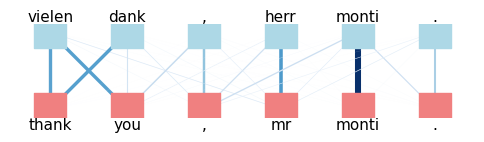

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Sample data

# Create a bipartite graph
G = nx.Graph()

# Add German nodes
for i in range(len(src_str)):
    G.add_node(f'German_{src_str[i]}')

# Add English nodes
for j in range(len(tgt_str)):
    G.add_node(f'English_{tgt_str[j]}')

# Add edges with weights
for i in range(len(src_str)):
    for j in range(len(tgt_str)):
        weight = attn_map[i][j]
        G.add_edge(f'German_{src_str[i]}', f'English_{tgt_str[j]}', weight=weight)

# Draw the graph
plt.figure(figsize=(6, 8))  # Adjust the figure size
pos = {}
for i, node in enumerate(src_str):
    pos[f'German_{node}'] = (i, 1)
for j, node in enumerate(tgt_str):
    pos[f'English_{node}'] = (j, 0)  # Adjust the y-coordinate for English nodes

# Draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in G.nodes if node.startswith('German')],
                       node_shape='s', node_color='lightblue', node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in G.nodes if node.startswith('English')],
                       node_shape='s', node_color='lightcoral', node_size=500)

# Draw edges with thickness proportional to weight
edge_weights = [G[u][v]['weight'] * 5 for u, v in G.edges()]
cmap = plt.cm.Blues  # Define a colormap
norm = mcolors.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
edge_colors = [cmap(norm(weight)) for weight in edge_weights]
nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color=edge_colors)

# Draw labels
for node, (x, y) in pos.items():
    if node.startswith('German'):
        plt.text(x, y + 0.2, node.split("_")[-1], ha='center', va='center', fontsize=11)
    else:  # For English nodes, place labels above
        plt.text(x, y - 0.2, node.split("_")[-1], ha='center', va='center', fontsize=11)

plt.gca().set_aspect('equal', adjustable='box')  # Make the aspect ratio equal to avoid distortion

plt.axis('off')
plt.show()